In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the basic block for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Identity shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)

# Define the ResNet-34 Model
class ResNet34(nn.Module):
    def __init__(self, num_classes=102):
        super(ResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define layers
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [2]:
# Flower dataset transformation and loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
test_dataset = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 345M/345M [00:14<00:00, 24.4MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 399kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 13.4MB/s]


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet34(num_classes=102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')


Epoch [1/40], Loss: 4.8656, Accuracy: 1.57%
Epoch [2/40], Loss: 4.3300, Accuracy: 2.06%
Epoch [3/40], Loss: 4.1602, Accuracy: 3.73%
Epoch [4/40], Loss: 4.0392, Accuracy: 4.61%
Epoch [5/40], Loss: 3.9650, Accuracy: 5.78%
Epoch [6/40], Loss: 3.7536, Accuracy: 7.65%
Epoch [7/40], Loss: 3.6781, Accuracy: 8.24%
Epoch [8/40], Loss: 3.5722, Accuracy: 11.18%
Epoch [9/40], Loss: 3.4479, Accuracy: 11.86%
Epoch [10/40], Loss: 3.3869, Accuracy: 13.82%
Epoch [11/40], Loss: 3.3210, Accuracy: 14.22%
Epoch [12/40], Loss: 3.2441, Accuracy: 15.49%
Epoch [13/40], Loss: 3.1070, Accuracy: 19.31%
Epoch [14/40], Loss: 3.0137, Accuracy: 20.88%
Epoch [15/40], Loss: 2.9836, Accuracy: 19.41%
Epoch [16/40], Loss: 2.9223, Accuracy: 21.86%
Epoch [17/40], Loss: 2.7244, Accuracy: 26.67%
Epoch [18/40], Loss: 2.6531, Accuracy: 27.55%
Epoch [19/40], Loss: 2.6925, Accuracy: 26.76%
Epoch [20/40], Loss: 2.4633, Accuracy: 32.16%
Epoch [21/40], Loss: 2.3305, Accuracy: 35.49%
Epoch [22/40], Loss: 2.2695, Accuracy: 34.71%
Epoc

In [32]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')


Accuracy of the model on the test set: 86.75%


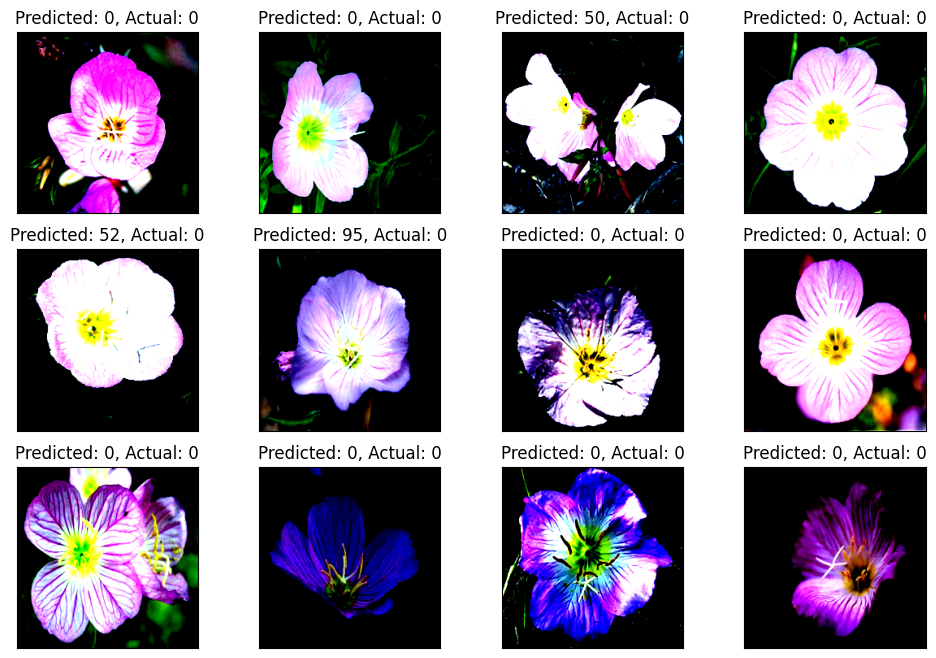

In [39]:
import numpy as np

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get predictions
model.eval()
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 8))
for idx in np.arange(12):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
    ax.set_title(f"Predicted: {preds[idx].item()}, Actual: {labels[idx].item()}")
plt.show()
